<a href="https://colab.research.google.com/github/stoiver/anuga-clinic-2018/blob/master/notebooks/notebook5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSDMS ANUGA Clinic 2018

## Notebook 5: Monai Valley Tsunami runup 

Validation of the AnuGA implementation of the shallow water wave equation.
This script sets up Okushiri Island benchmark as published at the

The Third International Workshop on Long-Wave Runup Models
June 17-18 2004

Wrigley Marine Science Center
Catalina Island, California
http://www.cee.cornell.edu/longwave/


The validation data was downloaded and made available in this directory
for convenience but the original data is available at
http://www.cee.cornell.edu/longwave/index.cfm?page=benchmark&problem=2
where a detailed description of the problem is also available.


### Installation

These notebooks have been designed to run in the google `colaboratory` environment, which provides a jupyter notebook environment running on a virtual machine on the cloud. To use this environment you need a google account so that your notebook can be saved on google drive. 

To start interacting with the notebook follow the 
`View in Colaboratory` link above. 

## Setup Environment

If on github, first follow the link `View in Colaboratory' to start running on google's colab environment. Then ....

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory.

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. 

The install should take less than a minute (and quicker if you have already run this earlier).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
  # On colab we can install all the packages we need via the notebook
  #
  # First download the clinic repository
  import os
  os.chdir('/content')
  !git clone https://github.com/stoiver/anuga-clinic-2018.git

  # Now install environment using tool
  !/bin/bash /content/anuga-clinic-2018/anuga_tools/install_anuga_colab.sh
 
except:
  pass

# Make inline animate code available
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

import sys
sys.path.append(os.path.join(workbookDir,"anuga-clinic-2018"))

fatal: destination path 'anuga-clinic-2018' already exists and is not an empty directory.
(1) Install netcdf nose via pip
(2) Install gdal via apt-get
(3) Download anuga_core github repository
(4) Install anuga
(5) Ready to go


### Import ANUGA and Tools

Once `anuga` and `anuga_clinic-2018` have been installed we can now `import` our standard libraries.

In [0]:
%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

import anuga
import anuga_tools.animate as animate

## The Code 

This code is taken from `anuga_core/validation_tests/experimental_data/okishuri/run_okishuri.py`.


In [0]:
# Given boundary wave
boundary_filename = '/content/anuga-clinic-2018/data/Okushiri/Benchmark_2_input.txt'

# Observed timeseries
validation_filename = '/content/anuga-clinic-2018/data/Okushiri/output_ch5-7-9.txt'

# Digital Elevation Model
bathymetry_filename = '/content/anuga-clinic-2018/data/Okushiri/Benchmark_2_Bathymetry.xya'

# Model output
output_filename = 'okushiri.sww'

### Parameters to Setup Domain



number of Elements  28609
Figure files for each frame will be stored in _plot


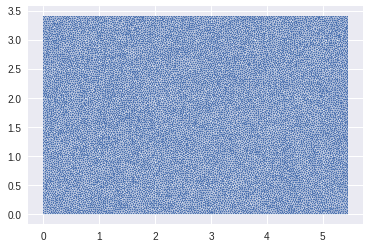

In [4]:
base_resolution = 0.005


# Basic geometry and bounding polygon
xleft   = 0
xright  = 5.448
ybottom = 0
ytop    = 3.402

point_sw = [xleft, ybottom]
point_se = [xright, ybottom]
point_nw = [xleft, ytop]    
point_ne = [xright, ytop]

bounding_polygon = [point_se,
                    point_ne,
                    point_nw,
                    point_sw]




domain = anuga.create_domain_from_regions(bounding_polygon,
                                 boundary_tags={'wall': [0, 1, 3],
                                                'wave': [2]},     
                                 maximum_triangle_area=base_resolution,
                                 use_cache=False,
                                 verbose=False)

#domain.print_statistics()
print 'Number of Elements ', domain.number_of_elements

dplotter = animate.Domain_plotter(domain, min_depth=0.001)  
plt.triplot(dplotter.triang, linewidth = 0.4);

### Load Barthymetry Data

Using in the barthymetry data provided from the workshop. We need to reshape the data and form a raster (x,y,Z).

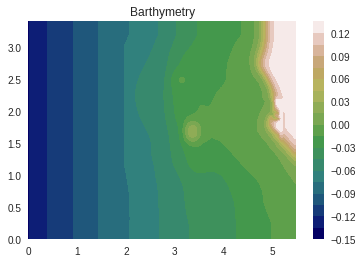

In [5]:
xya = np.loadtxt(bathymetry_filename, skiprows=1, delimiter=',')
  
X = xya[:,0].reshape(393,244)
Y = xya[:,1].reshape(393,244)
Z = xya[:,2].reshape(393,244)


plt.contourf(X,Y,Z, 20, cmap=plt.get_cmap('gist_earth'));
plt.title('Barthymetry')
plt.colorbar();

# Create raster tuple
x = X[:,0]
y = Y[0,:]
Zr = np.flipud(Z.T)

raster = x,y,Zr

### Apply Barthymetry to Domain


(393, 244)


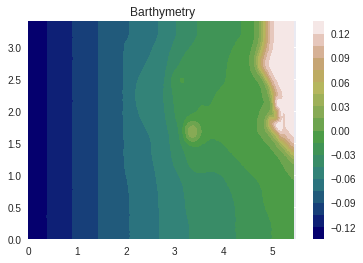

In [6]:
domain.set_quantity('elevation',raster=raster, location='centroids')


zv = domain.get_quantity('elevation').get_values(location='unique vertices')


import matplotlib.tri as mtri

interp_lin = mtri.LinearTriInterpolator(dplotter.triang, zv)
Z = interp_lin(X, Y)
print Z.shape

plt.contourf(X,Y,Z, 20, cmap=plt.get_cmap('gist_earth'));
plt.title('Barthymetry')
plt.colorbar();



### Evolve



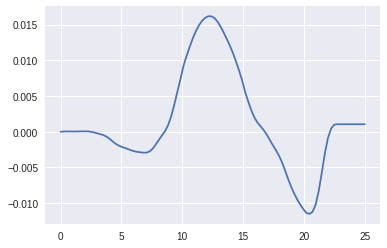

In [7]:
bdry = np.loadtxt(boundary_filename, skiprows=1)

bdry_t = bdry[:,0]
bdry_v = bdry[:,1]


import scipy
wave_function = scipy.interpolate.interp1d(bdry_t, bdry_v, kind='zero', fill_value='extrapolate')

t = np.linspace(0.0,25.0, 100)

plt.plot(t,wave_function(t));

In [0]:


#-------------------------
# Initial Conditions
#-------------------------
domain.set_quantity('friction', 0.0025)
domain.set_quantity('stage', 0.0)

verbose = True

#-------------------------
# Set simulation parameters
#-------------------------
domain.set_name(output_filename)  # Name of output sww file 
domain.set_minimum_storable_height(0.001) # Don't store w-z < 0.001m


#-------------------------
# Boundary Conditions
#-------------------------



# Create and assign boundary objects
Bts = anuga.Transmissive_n_momentum_zero_t_momentum_set_stage_boundary(domain, wave_function)
Br = anuga.Reflective_boundary(domain)
domain.set_boundary({'wave': Bts, 'wall': Br})




In [0]:
# area for gulleys
x1 = 4.85
x2 = 5.25
y1 = 2.05
y2 = 1.85

# index in gulley area
x = domain.centroid_coordinates[:,0]
y = domain.centroid_coordinates[:,1]
v = np.sqrt( (x-x1)**2 + (y-y1)**2 ) + np.sqrt( (x-x2)**2 + (y-y2)**2 ) < 0.5

gauge = [[4.521, 1.196],  [4.521, 1.696],  [4.521, 2.196]] #Ch 5-7-9
bdyloc = [0.00001, 2.5]
g5_id = domain.get_triangle_containing_point(gauge[0])
g7_id = domain.get_triangle_containing_point(gauge[1])
g9_id = domain.get_triangle_containing_point(gauge[2])
bc_id = domain.get_triangle_containing_point(bdyloc)

meanstage = np.nan*np.ones((451,))
g5 = np.nan*np.ones((451,))
g7 = np.nan*np.ones((451,))
g9 = np.nan*np.ones((451,))
bc = np.nan*np.ones((451,))


Stage = domain.quantities['stage'].centroid_values
stage_qoi = Stage[v]

k = 0
for t in domain.evolve(yieldstep=0.05, finaltime=22.5):

    domain.print_timestepping_statistics()
    
    # stage    
    meanstage[k] = np.mean(stage_qoi)
    g5[k] = Stage[g5_id]
    g7[k] = Stage[g7_id]
    g9[k] = Stage[g9_id]
                    
    dplotter.save_depth_frame()


# Read in the png files stored during the evolve loop
dplotter.make_depth_animation()

### View Time  Series

In [0]:
plt.plot(g5)